# **Sesión 3: Procesamiento Avanzado de Imágenes** ⚙️🖼️

## **Instalaciones**

In [1]:
!pip install tqdm scikit-learn openpyxl pandas matplotlib


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## **Librerías**

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from bow import BoW
from dataset import Dataset
from image_classifier import ImageClassifier
import time
from tqdm import tqdm
import sys
import pickle


# **Apartado C**: Detección de puntos de interés y Bolsa de palabras

## **C1: Detección de puntos de interés**

### **Tarea C.1.1**: Generar función de filtro gaussiano

Se generará a partir de la imagen base las imágenes con el filtrado gaussiano. Para ello se empleará la función `generateGaussianImages()` que tiene que desarrollar empleando la función [`cv2.GaussianBlur()`](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gae8bdcd9154ed5ca3cbc1766d960f45c1). Es recomendble visualizar los resultados para comprobar el funcionamiento. Para ello convierta los datos de la imagen a visualizar a `np.uint8`

In [3]:
def show_image(img: np.array, img_name: str = "Image"):
    cv2.imshow(img_name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [4]:
def generateGaussianImages(image, sigmas):
    """Generate the gaussian images using the base image and the sigmas given

    Args:
        image (np.array[np.float32]): Base image to blur
        sigmas (List[np.float32]): Sigmas for blurring the image 

    Returns:
        List[np.array[np.float32]: List of blurred images
    """
    gaussian_images = []

    for i,sigma in enumerate(sigmas):
        image = cv2.GaussianBlur(image, (0,0), sigmaX = sigma)
        gaussian_images.append(image)
        cv2.imshow(f"Kernel: {i}", image.astype(np.uint8))
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return gaussian_images
    

### **Tarea C.1.2**: Generación de espacio de escalas con imágenes gaussianas

Empleando la función anterior, complete la siguiente celda para generar las imágenes gaussianas

In [5]:
# TODO: Load the image in grayscale
image = cv2.imread('../data/0.jpg', cv2.IMREAD_GRAYSCALE)
image = image.astype(np.float32)

# Number of difference of gaussians to generate (minimum 3)
# TODO: Adjust this number to make sure keypoints are generated
intervals = 5

# Initial sigma
sigma = 1.6 

def generateGaussianSigmas(initial_sigma, intervals):
    return [initial_sigma * (2 ** (i / 2)) for i in range(intervals)]

sigmas = generateGaussianSigmas(sigma, intervals)

# TODO: Generate the gaussian images
gaussian_images = generateGaussianImages(image, sigmas)



### **Tarea C.1.3**: Generación de diferencias de gaussianas

Utilizando la lista de imágenes gaussianas se generará una lista con las diferencias entre pares consegutivos. Para ello se empleará la función `generateDoGImages()` que tiene que desarrollar empleando la función [`cv2.subtract()`](https://docs.opencv.org/4.x/d2/de8/group__core__array.html#gaa0f00d98b4b5edeaeb7b8333b2de353b)

In [6]:
def generateDoGImages(gaussian_images):
    """Generate Difference-of-Gaussians list

    Args:
        gaussian_images (List[np.array[np.float32]): List of blurred images

    Returns:
        List[np.array[np.float32]: List of difference of gaussian images
    """
    dog_images = []

    for i in range(1, len(gaussian_images)):
        # TODO: Generate the list of difference of gaussians using cv2.subtract()
        dog_img = cv2.subtract(gaussian_images[i], gaussian_images[i - 1])
        dog_images.append(dog_img) 
    
    return dog_images

dog_images_ = generateDoGImages(gaussian_images)
dog_images = []
for i, dog_img in enumerate(dog_images_):
    # Convertir la imagen a uint8 para visualizar
    dog_img_display = np.uint8(np.clip((dog_img >= 2) * 255, 0, 255))
    dog_images.append(dog_img_display)
    show_image(dog_img_display, f'DoG Image {i+1}')


### **Tarea C.1.4**: Evaluación de extremos

La función `isPixelAnExtremum()` debe evaluar si el pixel central del bloque compuesto por las regiones de las 3 imágenes es un máximo o mínimo entre ellos. Como prevención, tenga en cuenta que puede tomar valores positivos y negativos

In [7]:
def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    """Return True if the center element of the 3x3x3 array composed of subimages is strictly greater than or less than all its neighbors, False otherwise

    Args:
        first_subimage (np.array): Patch from first gaussian
        second_subimage (np.array): Patch from second gaussian
        third_subimage (np.array): Patch from third gaussian
        threshold (float): Value threshold for the pixel

    Returns:
        Bool: True if maximum or minimum, False otherwise
    """
    extremum = False
    center_pixel = second_subimage[1, 1]  # Obtener el valor del píxel central

    # Comprobar si el píxel central es un máximo o un mínimo
    is_maximum = all(center_pixel >= neighbor for neighbor in first_subimage.flatten()) and \
                  all(center_pixel >= neighbor for neighbor in second_subimage.flatten()) and \
                  all(center_pixel >= neighbor for neighbor in third_subimage.flatten())

    is_minimum = all(center_pixel <= neighbor for neighbor in first_subimage.flatten()) and \
                  all(center_pixel <= neighbor for neighbor in second_subimage.flatten()) and \
                  all(center_pixel <= neighbor for neighbor in third_subimage.flatten())

    if (is_maximum or is_minimum) and abs(center_pixel) > threshold:
        extremum = True

    return extremum

In [8]:
first_subimage = np.zeros((3,3),np.float32)
third_subimage = np.zeros((3,3),np.float32)
second_subimage = np.ones((3,3),np.float32)
isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold=0.03)

True

### **Tarea C.1.5**: Localización de puntos clave y orientación de los mismos

La función `findScaleSpaceExtrema()` obtendrá los puntos clave y su orientación a partir de las gaussianas y sus diferencias empleando, entre otras, la función `isPixelAnExtremum()`. Deberá completar las partes indicadas para recorrer todos los trios de imágenes consecutivos y evaluar los píxeles necesarios de estos.

Total keypoints found before deduplication: 355
Total keypoints after deduplication: 334


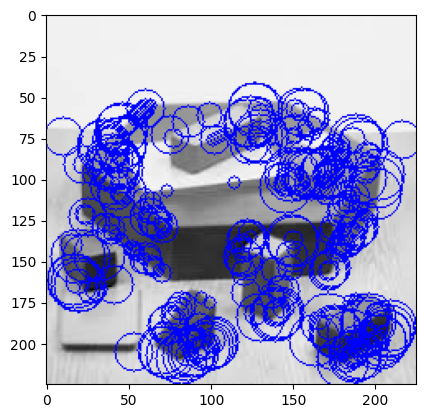

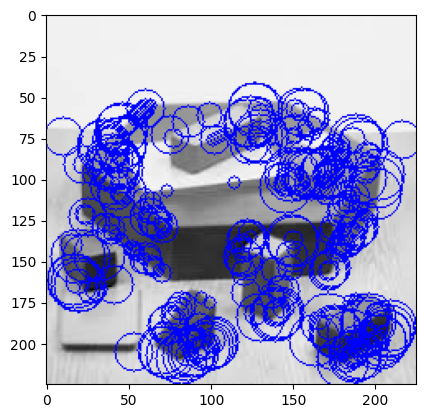

In [9]:
def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, threshold=0.03):
    """Find pixel positions of all scale-space extrema in the image pyramid and assign orientations"""
    keypoints = []

    for image_index in range(len(dog_images)-2):
        first_image = dog_images[image_index]
        second_image = dog_images[image_index + 1]
        third_image = dog_images[image_index + 2]
        
        height, width = second_image.shape

        # Iterate over each pixel in the current DoG image, excluding the borders
        for i in range(1, height - 1):
            for j in range(1, width - 1):
                # Check if the pixel is an extremum
                if isPixelAnExtremum(
                    first_image[i - 1:i + 2, j - 1:j + 2],
                    second_image[i - 1:i + 2, j - 1:j + 2],
                    third_image[i - 1:i + 2, j - 1:j + 2],
                    threshold
                ):
                    # Refine localization
                    localization_result = localizeExtremumViaQuadraticFit(
                        i, j, image_index + 1, num_intervals, dog_images, sigma
                    )
                    
                    if localization_result is not None:
                        keypoint, localized_image_index = localization_result
                        
                        # Compute orientations for the refined keypoint
                        keypoints_with_orientations = computeKeypointsWithOrientations(
                            keypoint, gaussian_images[localized_image_index]
                        )
                        
                        for keypoint_with_orientation in keypoints_with_orientations:
                            keypoints.append(keypoint_with_orientation)
    
    # Log the total keypoints found
    print(f"Total keypoints found before deduplication: {len(keypoints)}")
    
    # Remove duplicate keypoints
    keypoints = removeDuplicateKeypoints(keypoints)
    print(f"Total keypoints after deduplication: {len(keypoints)}")

    return keypoints

# Example usage:
threshold = 100
keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, 3, sigma, threshold)

# Visualize the initial keypoints
visualizeKp(image, keypoints)

# Visualize deduplicated keypoints
keypoints = removeDuplicateKeypoints(keypoints)
visualizeKp(image, keypoints)


Con los puntos clave totalmente definidos y las imágenes gaussianas ya podemos obtener los descriptores con la función proporcionada de `generateDescriptors()`

In [10]:
descriptors = generateDescriptors(keypoints, gaussian_images)

### **Tarea C.1.6**: Pipeline de generación de puntos clave y descriptores

Complete la función con los métodos desarrollados en tareas previas para generar los puntos clave y descriptores necesarios dada una imagen, un valor de sigma y un número de diferencias de gaussianas

In [16]:
def generateGaussianKernels(sigma, num_intervals):
    num_levels = num_intervals + 3
    k = 2 ** (1 / num_intervals)  # scale multiplier per interval
    gaussian_kernels = [sigma]

    for i in range(1, num_levels):
        sigma_prev = (k ** (i - 1)) * sigma
        sigma_total = k * sigma_prev
        gaussian_kernels.append(np.sqrt(sigma_total ** 2 - sigma_prev ** 2))

    return gaussian_kernels

def computeKeypointsAndDescriptors(image, sigma=1.6, num_intervals=3):
    """Compute SIFT keypoints and descriptors for an input image"""
    image = image.astype('float32')    
    gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
    gaussian_images = generateGaussianImages(image, gaussian_kernels)
    dog_images = generateDoGImages(gaussian_images)
    keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, threshold=0.03)
    descriptors = generateDescriptors(keypoints, gaussian_images)
    return keypoints, descriptors


### **Tarea C.1.7**: Correspondencia de características entre imágenes

Cargue las imágenes con `cv2` y complete la llamada a la función previa

In [17]:
# TODO: Load the images with cv2 in grayscale
img1 = cv2.imread('../data/0.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('../data/0_rot.jpg', cv2.IMREAD_GRAYSCALE)

# TODO: Fill the function calls
kp1, des1 = computeKeypointsAndDescriptors(img1)
kp2, des2 = computeKeypointsAndDescriptors(img2)

# Match features between the two images
matchFeatures(img1, kp1, des1, img2, kp2, des2)

Total keypoints found before deduplication: 7
Total keypoints after deduplication: 7
Total keypoints found before deduplication: 7
Total keypoints after deduplication: 7
Not enough matches are found - 7/10


#### **Ampliación**: SIFT con OpenCV

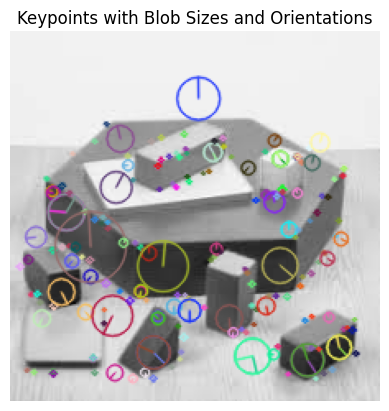

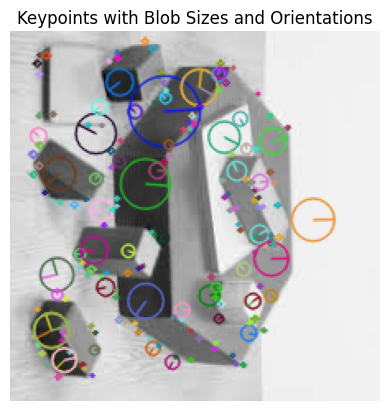

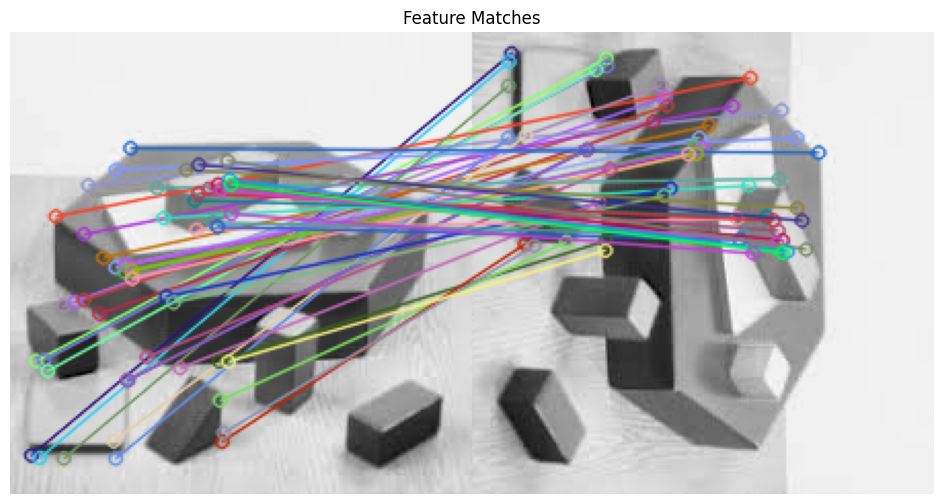

In [13]:
# Load the image
image_0 = cv2.imread('../data/0.jpg', cv2.IMREAD_GRAYSCALE)
image_1 = cv2.imread('../data/0_rot.jpg', cv2.IMREAD_GRAYSCALE)

# Create a SIFT detector object
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints_0, descriptors_0 = sift.detectAndCompute(image_0, None)
keypoints_1, descriptors_1 = sift.detectAndCompute(image_1, None)

# Draw keypoints on the image
image_with_keypoints_0 = cv2.drawKeypoints(image_0, keypoints_0, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image_with_keypoints_1 = cv2.drawKeypoints(image_1, keypoints_1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(image_with_keypoints_0)
plt.title('Keypoints with Blob Sizes and Orientations')
plt.axis('off')
plt.show()
plt.imshow(image_with_keypoints_1)
plt.title('Keypoints with Blob Sizes and Orientations')
plt.axis('off')
plt.show()

# Initialize BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

# Perform KNN matching with k=2 for ratio test
matches = bf.match(descriptors_0, descriptors_1)

# sort matches by distance
matches = sorted(matches, key = lambda x:x.distance)


# Draw the good matches
matched_image = cv2.drawMatches(image_0, keypoints_0, image_1, keypoints_1, matches[:50], None,
                                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matched features
plt.figure(figsize=(12, 6))
plt.imshow(matched_image)
plt.title("Feature Matches")
plt.axis('off')
plt.show()

### **Pregunta C1**: Correspodencia de imágenes propias y evaluación

In [18]:
# TODO: Homework
def match_images(image1, image2):
    # Cargar las imágenes en escala de grises
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    # Inicializar el detector SIFT
    sift = cv2.SIFT_create()

    # Detectar puntos clave y descriptores
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)
    
    # Crear un emparejador FLANN
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    
    # Emparejar los descriptores
    matches = bf.match(des1, des2)
    
    # Ordenar los emparejamientos por distancia (más cerca es mejor)
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Dibujar las correspondencias
    img_matches = cv2.drawMatches(image1, kp1, image2, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    return img_matches

# Cargar las imágenes
image1 = cv2.imread('../data/0.jpg')
image2 = cv2.imread('../data/0_rot.jpg')

# Llamar a la función de emparejamiento
result_image = match_images(image1, image2)

# Mostrar las correspondencias
cv2.imshow("Matches", result_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

## **C2: Bolsa de palabras**

### **Tarea C.2.1**: Carga de los datasets de entrenamiento y validación para la bolsa de palabras

Empleando el método `load()` de la clase [`Dataset`](.\dataset.py) que se le proporciona, cargue los datasets de entrenamiento y validación.

In [23]:
training_set = Dataset.load("../data/dataset/training", "*.jpg")
validation_set = Dataset.load("../data/dataset/validation", "*.jpg")
training_set

['../data/dataset/training\\Bedroom\\image_0003.jpg',
 '../data/dataset/training\\Bedroom\\image_0004.jpg',
 '../data/dataset/training\\Bedroom\\image_0006.jpg',
 '../data/dataset/training\\Bedroom\\image_0007.jpg',
 '../data/dataset/training\\Bedroom\\image_0008.jpg',
 '../data/dataset/training\\Bedroom\\image_0011.jpg',
 '../data/dataset/training\\Bedroom\\image_0013.jpg',
 '../data/dataset/training\\Bedroom\\image_0014.jpg',
 '../data/dataset/training\\Bedroom\\image_0016.jpg',
 '../data/dataset/training\\Bedroom\\image_0017.jpg',
 '../data/dataset/training\\Bedroom\\image_0018.jpg',
 '../data/dataset/training\\Bedroom\\image_0019.jpg',
 '../data/dataset/training\\Bedroom\\image_0020.jpg',
 '../data/dataset/training\\Bedroom\\image_0021.jpg',
 '../data/dataset/training\\Bedroom\\image_0024.jpg',
 '../data/dataset/training\\Bedroom\\image_0026.jpg',
 '../data/dataset/training\\Bedroom\\image_0029.jpg',
 '../data/dataset/training\\Bedroom\\image_0030.jpg',
 '../data/dataset/training\\

### **Tarea C.2.2**: Extracción de los descriptores

Para poder crear la bolsa de palabras se va a comenzar obteniendo los descriptores que serán agrupados en las distintas palabras de nuestra bolsa. Para ello complete la carga de la imagen en la ruta `path` en escala de grises y obtenga sus descriptores con los métodos apropiados de cv2. Los descriptores obtenidos se añadirán a nuestra bolsa de palabras (`words`) para después ser agrupados por palabras que representen

In [24]:
feature_extractor = cv2.SIFT_create()

# Extract features
print("\nComputing SIFT descriptors...")
time.sleep(0.1)  # Prevents a race condition between tqdm and print statements.
descriptors = []
for path in tqdm(training_set, unit="image", file=sys.stdout):
    # TODO: Load the image from the path in grayscale
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    try:
        # TODO: Using the cv2 methods get the descriptors for the image
        _, descriptor = feature_extractor.detectAndCompute(image, None)
    except:
        print(f"WARN: Issue generating descriptor for image {path}")

if descriptor is not None:
    descriptors.append(descriptor)



Computing SIFT descriptors...
100%|██████████| 2981/2981 [00:39<00:00, 74.88image/s]


### **Tarea C.2.3**: Creación del vocabulario

Añada los descriptores a la bolsa (`words`) con el método add de la misma. Con los descriptores en la bolsa, se va a realizar el agrupamiento de los mismos por palabras para obtener un vocabulario de palabras visuales. Complete la ruta de apertura del archivo y establezca el modo de apertura en escrituria y bineario para poder guardar el vocabulario generado.

In [26]:
# Build vocabulary
vocabulary_size = 100
iterations = 15
termination_criteria = (cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_EPS, iterations, 1e-6)
words = cv2.BOWKMeansTrainer(vocabulary_size, termination_criteria)

# TODO: Add all descriptors
for descriptor in descriptors:  # Asumiendo que 'descriptors' ya está lleno con los descriptores
    words.add(descriptor)

time.sleep(0.1)  # Prevents a race condition between tqdm and print statements.
print("\nClustering descriptors into", vocabulary_size, "words using K-means...")
vocabulary = words.cluster()

# Save vocabulary to a file
filename = "vocabulary.pickle"
with open(filename, 'wb') as f:  # Opening file in write-binary mode
    pickle.dump(["SIFT", vocabulary], f, pickle.HIGHEST_PROTOCOL)


Clustering descriptors into 100 words using K-means...


### **Tarea C.2.4**: Entrenamiento del clasificador

Una vez se tiene el vocabulario de palabras visuales, se va a entrenar al classificador. Para ello haga uso de la clase [BoW](./bow.py) y complete los métodos que se le indican

In [27]:
bow = BoW()

vocabulary_filename = "vocabulary"
bow.load_vocabulary(vocabulary_filename)

image_classifier = ImageClassifier(bow)

# Asegúrate de que el método 'train' esté correctamente implementado
image_classifier.train(training_set)

# Guardar el clasificador entrenado en un archivo
classifier_filename = "classifier"
image_classifier.save(classifier_filename)

print(f"Classifier saved to {classifier_filename}")



TRAINING CLASSIFIER

Extracting features...
100%|██████████| 2981/2981 [01:01<00:00, 48.29image/s]

Training SVM...
Classifier saved to classifier


### **Tarea C.2.5**: Inferencia en dataset de entrenamiento
Con el modelo entrenado se procede a comprobar su desempeño con el dataset de entrenamiento. Complete los métodos indicados

In [28]:
bow = BoW()
# TODO: Especify the args for the loading method
bow.load_vocabulary("vocabulary")

image_classifier = ImageClassifier(bow)
# TODO: Especify the args for the loading method
image_classifier.load("classifier")

# TODO: Especify the args for the loading method
image_classifier.predict(validation_set)



CLASSIFICATION RESULTS

Confusion matrix

KNOWN/PREDICTED  Bedroom  Coast  Forest  Highway  Industrial  Inside city  Kitchen  Living room  Mountain  Office  Open country  Store  Street  Suburb  Tall building
Bedroom             17.0    8.0     1.0      1.0         9.0          8.0      2.0         26.0       1.0     5.0           4.0    9.0     2.0     3.0            4.0
Coast                0.0   63.0     1.0      5.0         0.0          0.0      0.0          2.0      14.0     0.0          12.0    0.0     0.0     2.0            1.0
Forest               0.0    0.0    84.0      0.0         0.0          0.0      0.0          0.0       3.0     0.0          10.0    3.0     0.0     0.0            0.0
Highway              1.0   32.0     0.0     25.0         3.0         11.0      1.0          0.0       6.0     0.0           4.0    0.0     5.0     7.0            5.0
Industrial           2.0    4.0     0.0      4.0        29.0         19.0      1.0          4.0       3.0     5.0           5.

(0.43866666666666665,
 array([[17.,  8.,  1.,  1.,  9.,  8.,  2., 26.,  1.,  5.,  4.,  9.,  2.,  3.,  4.],
        [ 0., 63.,  1.,  5.,  0.,  0.,  0.,  2., 14.,  0., 12.,  0.,  0.,  2.,  1.],
        [ 0.,  0., 84.,  0.,  0.,  0.,  0.,  0.,  3.,  0., 10.,  3.,  0.,  0.,  0.],
        [ 1., 32.,  0., 25.,  3., 11.,  1.,  0.,  6.,  0.,  4.,  0.,  5.,  7.,  5.],
        [ 2.,  4.,  0.,  4., 29., 19.,  1.,  4.,  3.,  5.,  5.,  9.,  7.,  3.,  5.],
        [ 1.,  3.,  0.,  1.,  8., 55.,  2.,  4.,  0.,  0.,  4.,  6.,  5.,  3.,  8.],
        [13.,  1.,  0.,  1., 11., 13., 11., 18.,  0., 12.,  2.,  8.,  2.,  7.,  1.],
        [ 7.,  2.,  0.,  0., 18.,  0.,  4., 38.,  2.,  9.,  1.,  4.,  3.,  5.,  7.],
        [ 2., 10., 10.,  0.,  1.,  0.,  0.,  1., 63.,  0.,  8.,  1.,  3.,  1.,  0.],
        [ 7.,  2.,  0.,  2., 12., 21.,  2., 19.,  2., 25.,  0.,  3.,  0.,  3.,  2.],
        [ 1., 25.,  7.,  0.,  2.,  0.,  0.,  0., 18.,  0., 42.,  1.,  0.,  2.,  2.],
        [ 0.,  0.,  4.,  0., 12.,  7.,  1.,

### **Tarea C.2.6**: Inferencia en dataset de evaluación

A continuación se evalua el desempeño del modelo con el dataset de validación. Complete los métodos indicados

In [29]:
bow = BoW()
# TODO: Especify the args for the loading method
bow.load_vocabulary("vocabulary")

image_classifier = ImageClassifier(bow)
# TODO: Especify the args for the loading method
image_classifier.load("classifier")

# TODO: Especify the args for the loading method
image_classifier.predict(validation_set)



CLASSIFICATION RESULTS

Confusion matrix

KNOWN/PREDICTED  Bedroom  Coast  Forest  Highway  Industrial  Inside city  Kitchen  Living room  Mountain  Office  Open country  Store  Street  Suburb  Tall building
Bedroom             17.0    8.0     1.0      1.0         9.0          8.0      2.0         26.0       1.0     5.0           4.0    9.0     2.0     3.0            4.0
Coast                0.0   63.0     1.0      5.0         0.0          0.0      0.0          2.0      14.0     0.0          12.0    0.0     0.0     2.0            1.0
Forest               0.0    0.0    84.0      0.0         0.0          0.0      0.0          0.0       3.0     0.0          10.0    3.0     0.0     0.0            0.0
Highway              1.0   32.0     0.0     25.0         3.0         11.0      1.0          0.0       6.0     0.0           4.0    0.0     5.0     7.0            5.0
Industrial           2.0    4.0     0.0      4.0        29.0         19.0      1.0          4.0       3.0     5.0           5.

(0.43866666666666665,
 array([[17.,  8.,  1.,  1.,  9.,  8.,  2., 26.,  1.,  5.,  4.,  9.,  2.,  3.,  4.],
        [ 0., 63.,  1.,  5.,  0.,  0.,  0.,  2., 14.,  0., 12.,  0.,  0.,  2.,  1.],
        [ 0.,  0., 84.,  0.,  0.,  0.,  0.,  0.,  3.,  0., 10.,  3.,  0.,  0.,  0.],
        [ 1., 32.,  0., 25.,  3., 11.,  1.,  0.,  6.,  0.,  4.,  0.,  5.,  7.,  5.],
        [ 2.,  4.,  0.,  4., 29., 19.,  1.,  4.,  3.,  5.,  5.,  9.,  7.,  3.,  5.],
        [ 1.,  3.,  0.,  1.,  8., 55.,  2.,  4.,  0.,  0.,  4.,  6.,  5.,  3.,  8.],
        [13.,  1.,  0.,  1., 11., 13., 11., 18.,  0., 12.,  2.,  8.,  2.,  7.,  1.],
        [ 7.,  2.,  0.,  0., 18.,  0.,  4., 38.,  2.,  9.,  1.,  4.,  3.,  5.,  7.],
        [ 2., 10., 10.,  0.,  1.,  0.,  0.,  1., 63.,  0.,  8.,  1.,  3.,  1.,  0.],
        [ 7.,  2.,  0.,  2., 12., 21.,  2., 19.,  2., 25.,  0.,  3.,  0.,  3.,  2.],
        [ 1., 25.,  7.,  0.,  2.,  0.,  0.,  0., 18.,  0., 42.,  1.,  0.,  2.,  2.],
        [ 0.,  0.,  4.,  0., 12.,  7.,  1.,

### **Pregunta C.2.A**: Cambio de SIFT por Kaze

In [30]:
#TODO: Homework
feature_extractor = cv2.KAZE_create()

# Extraer los descriptores
print("\nComputing KAZE descriptors...")
time.sleep(0.1)  # Prevenir race condition entre tqdm y los prints.
descriptors = []
for path in tqdm(training_set, unit="image", file=sys.stdout):
    # Cargar la imagen en escala de grises
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    try:
        # Obtener los descriptores KAZE
        _, descriptor = feature_extractor.detectAndCompute(image, None)
    except:
        print(f"WARN: Issue generating descriptor for image {path}")

    if descriptor is not None:
        descriptors.append(descriptor)


Computing KAZE descriptors...
100%|██████████| 2981/2981 [02:09<00:00, 23.07image/s]


### **Pregunta C.2.B**: ¿Cuántas palabras uso?

In [ ]:
#TODO: Homework
print("Cuantas mas palabras se escogan mejor accuracy sale, pero el problema es que el tiempo de ejcucion aumente notablemente, hemos usado 100 para hacer el estudio")

### **EXTRA - Pregunta C.2.C**: Buscando los mejóres parámetros

In [ ]:
#TODO: Homework
